# Pneumothorax Segmentation using Deep Learning - (Keras version)

1. Introduction
2. Load data 
3. Visualize
4. Cost function and performance matrics
5. Design network 
6. Train and Visualize 
7. Conclusion and Further Discussion

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pydicom
import glob
import random
from skimage.transform import resize

import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras import Model
from tensorflow.keras import backend as K

%matplotlib inline

## Dataset

For this experiment, we are going to use Kaggle's Pneumothorax Segmentation challenge dataset. The competition page contains a lot more information about the challenge and the dataset. I highly recommended visiting that page and read more about the dataset and segmentation task. 

First of all, let's write a couple of utility functions to preprocess dataset and load data to NumPy arrays. 

### What is DICOM?

In [1]:
def mask2rle(img, width, height):
    rle = []
    lastColor = 0
    currentPixel = 0
    runStart = -1
    runLength = 0

    for x in range(width):
        for y in range(height):
            currentColor = img[x][y]
            if currentColor != lastColor:
                if currentColor == 255:
                    runStart = currentPixel
                    runLength = 1
                else:
                    rle.append(str(runStart))
                    rle.append(str(runLength))
                    runStart = -1
                    runLength = 0
                    currentPixel = 0
            elif runStart > -1:
                runLength += 1
            lastColor = currentColor
            currentPixel += 1

    return " ".join(rle)


def rle2mask(rle, width, height):
    mask = np.zeros(width * height)
    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]
    lengths = array[1::2]

    current_position = 0
    for index, start in enumerate(starts):
        current_position += start
        mask[current_position:current_position+lengths[index]] = 255
        current_position += lengths[index]

    return mask.reshape(width, height)


def generate_dataset(glob_pattern, labels, input_size=1024, output_size=256,
                     num_channels=1, validation_percentage=0.1):

    def helper(images):

        X_resized = np.zeros(
            (len(images), output_size, output_size, num_channels), dtype=np.float32)
        Y_resized = np.zeros(
            (len(images), output_size, output_size, 1), dtype=np.bool)

        X = np.zeros((len(images), input_size, input_size,
                      num_channels), dtype=np.uint8)
        Y = np.zeros((len(images), input_size, input_size, 1), dtype=np.bool)

        df_full = pd.read_csv(labels, index_col='ImageId')

        for n, image in enumerate(images):
            dataset = pydicom.read_file(image)
            X[n] = np.expand_dims(dataset.pixel_array, axis=2)
            try:
                if '-1' in df_full.loc[image.split('/')[-1][:-4], ' EncodedPixels']:
                    Y[n] = np.zeros((input_size, input_size, 1))
                else:
                    if type(df_full.loc[image.split('/')[-1][:-4], ' EncodedPixels']) == str:
                        Y[n] = np.expand_dims(
                            rle2mask(df_full.loc[image.split('/')[-1][:-4], ' EncodedPixels'],
                                     input_size, input_size).T, axis=2)
                    else:
                        Y[n] = np.zeros((input_size, input_size, 1))
                        for x in df_full.loc[image.split('/')[-1][:-4], ' EncodedPixels']:
                            Y[n] = Y[n] + \
                                np.expand_dims(
                                    rle2mask(x, input_size, input_size).T, axis=2)
            except KeyError:
                # Assume missing masks are empty masks.
                Y[n] = np.zeros((input_size, input_size, 1))

            X_resized[n] = resize(X[n], (output_size, output_size, 1))
            Y_resized[n] = resize(Y[n], (output_size, output_size, 1))

        return X_resized, Y_resized

    data_files = glob.glob(glob_pattern)
    dataset_size = len(data_files)
    valid_size = int(dataset_size*validation_percentage)
    train_size = dataset_size - valid_size
    print(f'dataset size           : {dataset_size} dicom files')
    print(f'training dataset size  : {train_size}  dicom files')
    print(f'validation dataset size: {valid_size}   dicom files')
    print('\n')

    random.shuffle(data_files)
    train_files = data_files[:train_size]
    valid_files = data_files[train_size:]

    print('generating training dataset')
    X_train, Y_train = helper(train_files)

    print('generating validation dataset')
    X_valid, Y_valid = helper(valid_files)

    return X_train, Y_train, X_valid, Y_valid

First two methods: `mask2rle` and `rle2mask` I borrowed from the competion page. These two utility functions we use for generating lables. `generate_dataset` is the main function we use for generating the dataset.

In [2]:
# Some useful constants
DATA_FOLDER = '../data/pneumothorax_segmentation/dicom-images-train/*/*/*.dcm'
LABEL_INFO = '../data/pneumothorax_segmentation/train-rle.csv'

In [3]:
X_train, Y_train, X_valid, Y_valid = generate_dataset(DATA_FOLDER, LABEL_INFO)

dataset size           : 12089 dicom files
training dataset size  : 10881  dicom files
validation dataset size: 1208   dicom files


generating training dataset
generating validation dataset


## Visualize Dataset

Let's write a simple utility function to display a few images. 

In [4]:
def display_images(num_rows, num_cols, X, Y=None):
    fig, axis = plt.subplots(nrows=num_rows, ncols=num_cols,
                             figsize=(num_cols*3, 6))
    counter = 0
    for i in range(num_rows):
        for j in range(num_cols):
            axis[i][j].imshow(X[counter, :, :, 0], cmap=plt.cm.bone)
            if type(Y) == np.ndarray:
                axis[i][j].imshow(Y[counter, :, :, 0], cmap='Reds', alpha=0.35)
            counter += 1
    plt.tight_layout()
    plt.show()

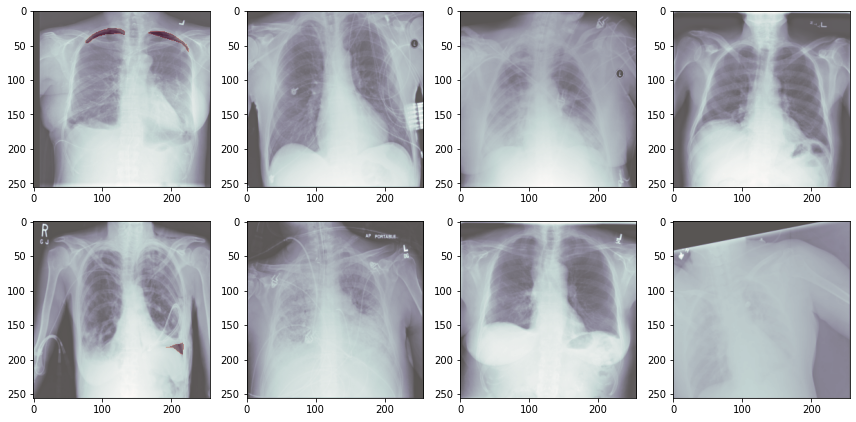

In [7]:
start = 1024
end = start + 8
display_images(num_cols=4, num_rows=2, X=X_train[start:end], Y=Y_train[start:end])

In [8]:
lable_data = pd.read_csv(LABEL_INFO)
lable_data.head(5)

,ImageId,EncodedPixels
0,1.2.276.0.7230010.3.1.4.8323329.6904.151787520...,-1
1,1.2.276.0.7230010.3.1.4.8323329.13666.15178752...,557374 2 1015 8 1009 14 1002 20 997 26 990 32 ...
2,1.2.276.0.7230010.3.1.4.8323329.11028.15178752...,-1
3,1.2.276.0.7230010.3.1.4.8323329.10366.15178752...,514175 10 1008 29 994 30 993 32 991 33 990 34 ...
4,1.2.276.0.7230010.3.1.4.8323329.10016.15178752...,592184 33 976 58 956 73 941 88 926 102 917 109...


In [9]:
def num_positive_and_negative(lables):
    num_pations = lables.shape[0]
    num_pos = 0
    num_neg = 0
    for i in range(num_pations):
        if np.any(lables[i, :, :, 0]):
            num_pos += 1
        else:
            num_neg += 1
    return num_pos, num_neg

num_pos, num_neg = num_positive_and_negative(Y_train)
assert (num_pos + num_neg) == Y_train.shape[0]

print(f'number of positive patients: {num_pos}')
print(f'number of negative patients: {num_neg}')

number of positive patients: 2395
number of negative patients: 8486


So it is clear that we are working with an imbalanced dataset. So we are going to use the **`soft-dice`** loss function. Also, we use **`dice-coefficient`** to measure the performance of our model.

In [10]:
def dice_coef(y_true, y_pred, smooth=0.00001):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2.0 * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

In [11]:
def soft_dice_loss(y_true, y_pred, axis=(1, 2, 3), 
                   epsilon=0.00001):
    """
    Compute mean soft dice loss over all abnormality classes.

    Args:
        y_true (Tensorflow tensor): tensor of ground truth values for all classes.
                                    shape: (num_classes, x_dim, y_dim, z_dim)
        y_pred (Tensorflow tensor): tensor of soft predictions for all classes.
                                    shape: (num_classes, x_dim, y_dim, z_dim)
        axis (tuple): spatial axes to sum over when computing numerator and
                      denominator in formula for dice loss.
                      Hint: pass this as the 'axis' argument to the K.sum
                            and K.mean functions.
        epsilon (float): small constant added to numerator and denominator to
                        avoid divide by 0 errors.
    Returns:
        dice_loss (float): computed value of dice loss.     
    """
    dice_numerator = K.sum(y_true * y_pred, axis=axis)
    dice_denominator = K.sum(K.square(y_true), axis=axis) + K.sum(K.square(y_pred), axis=axis)
    dice_loss = 1 - K.mean((2 * dice_numerator + epsilon) / (dice_denominator + epsilon))
    
    return dice_loss

## Model Building 

For this image segmentation task, We are going to develop a **`U-Net`** model. U-Net is a popular network type for medical image segmentation tasks.

The U-Net was first designed for a medical image segmentation task. Even with a small number of training examples, it can produce a relatively good performance. This is one of the key reasons for it has been used for may medical image segmentation tasks. 

In [18]:
class Unet(Model):
    def __init__(self):
        super(Unet, self).__init__()
        
        self.conv1 = Conv2D(32, 3, activation='relu', padding='same')
        self.conv2 = Conv2D(32, 3, activation='relu', padding='same')
        self.pool1 = MaxPooling2D(2, 2)
        
        
        self.conv3 = Conv2D(64, 3, activation='relu', padding='same')
        self.conv4 = Conv2D(64, 3, activation='relu', padding='same')
        self.pool2 = MaxPooling2D(2, 2)
        
        
        self.conv5 = Conv2D(128, 3, activation='relu', padding='same')
        self.conv6 = Conv2D(128, 3, activation='relu', padding='same')
        self.pool3 = MaxPooling2D(2, 2)
        
        self.conv7 = Conv2D(256, 3, activation='relu', padding='same')
        self.conv8 = Conv2D(256, 3, activation='relu', padding='same')
        self.pool4 = MaxPooling2D(2, 2)
        
        
        self.up_conv1 = Conv2DTranspose(256, 3, 2, padding='same')
        self.conv9 = Conv2D(256, 3, activation='relu', padding='same')
        self.conv10 = Conv2D(256, 3, activation='relu', padding='same')
        
        
        self.up_conv2 = Conv2DTranspose(128, 3, 2, padding='same')
        self.conv11 = Conv2D(128, 3, activation='relu', padding='same')
        self.conv12 = Conv2D(128, 3, activation='relu', padding='same')
        
        self.up_conv3 = Conv2DTranspose(62, 3, 2, padding='same')
        self.conv13 = Conv2D(64, 3, activation='relu', padding='same')
        self.conv14 = Conv2D(64, 3, activation='relu', padding='same')
        
        self.up_conv4 = Conv2DTranspose(32, 3, 2, padding='same')
        self.conv15 = Conv2D(32, 3, activation='relu', padding='same')
        self.conv16 = Conv2D(32, 3, activation='relu', padding='same')
        
        self.one_by_one = Conv2D(1, 1, activation='sigmoid')
        
    def call(self, x):
        x = self.conv1(x)
        conv_2 = self.conv2(x)
        x = self.pool1(conv_2)
        
        x = self.conv3(x)
        conv_4 = self.conv4(x)
        x = self.pool2(conv_4)
        
        x = self.conv5(x)
        conv_6 = self.conv6(x)
        x = self.pool3(conv_6)
        
        x = self.conv7(x)
        conv_8 = self.conv8(x)
        x = self.pool4(conv_8)
        
        x = self.up_conv1(x)
        x = concatenate([x, conv_8])
        x = self.conv9(x)
        x = self.conv10(x)
        
        x = self.up_conv2(x)
        x = concatenate([x, conv_6])
        x = self.conv11(x)
        x = self.conv12(x)
        
        x = self.up_conv3(x)
        x = concatenate([x, conv_4])
        x = self.conv13(x)
        x = self.conv14(x)
        
        x = self.up_conv4(x)
        x = concatenate([x, conv_2])
        x = self.conv15(x)
        x = self.conv16(x)
        
        output = self.one_by_one(x)
        return output

In [19]:
sanity_data = tf.random.normal(shape=(1, 256, 256, 1))
sanity_model = Unet()
output = sanity_model(sanity_data)
output.shape

TensorShape([1, 256, 256, 1])

In [24]:
model = Unet()
model.compile(optimizer='adam', loss=soft_dice_loss,
              metrics=[dice_coef])
model.fit(X_train, Y_train, validation_split=0.2, batch_size=32, epochs=1)

272/272 [==============================] - 3157s 12s/step - loss: 0.9667 - dice_coef: 0.0173 - val_loss: 0.9609 - val_dice_coef: 0.0249


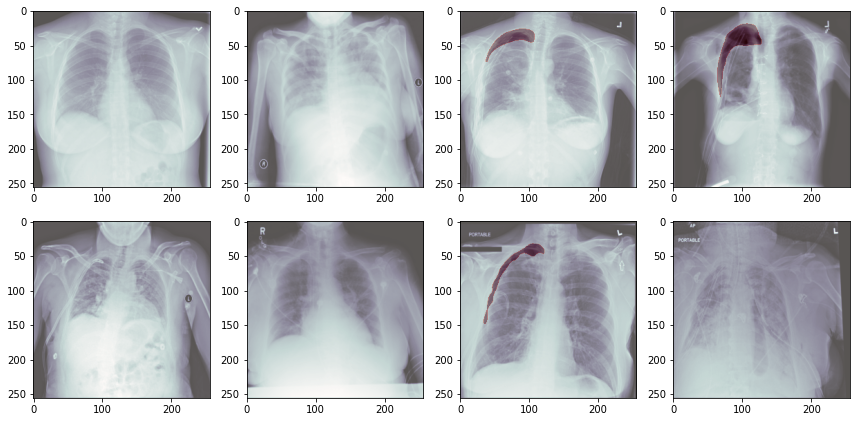

In [32]:
start = 0
end = start + 8
display_images(num_cols=4, num_rows=2, X=X_valid[start:end], Y=Y_valid[start:end])

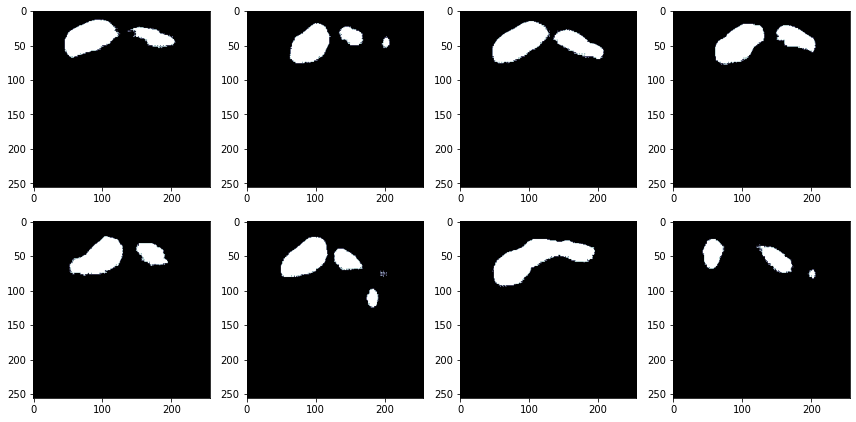

In [29]:
start = 0
end = start + 8
q = model.predict(X_valid)
qq = q > 0.5
display_images(num_cols=4, num_rows=2, X=qq[start:end])

In [25]:
##

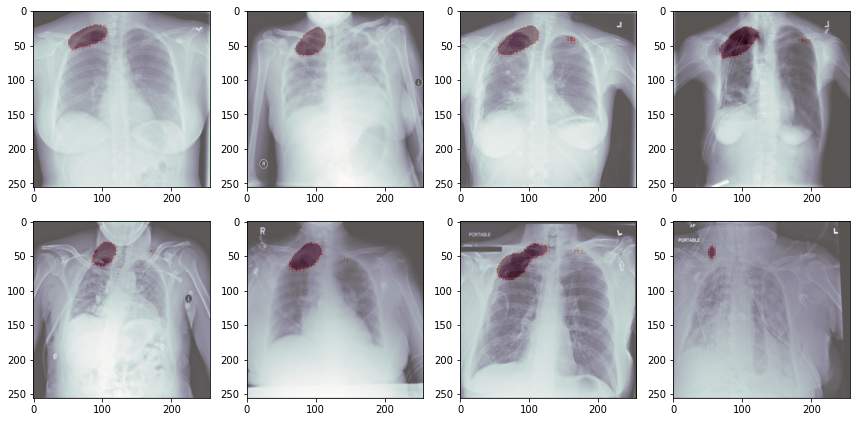

In [34]:
start = 0
end = start + 8
#q = model.predict(X_valid)
qq = q > 0.7
display_images(num_cols=4, num_rows=2, X=X_valid[start:end], Y=qq[start:end])

## Resources

1. U-Net: Convolutional Networks for Biomedical Image Segmentation [https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/]

2. U-Net Paper [https://arxiv.org/pdf/1505.04597.pdf]

3. UNet Introducing Symmetry in Segmentation [https://towardsdatascience.com/u-net-b229b32b4a71]